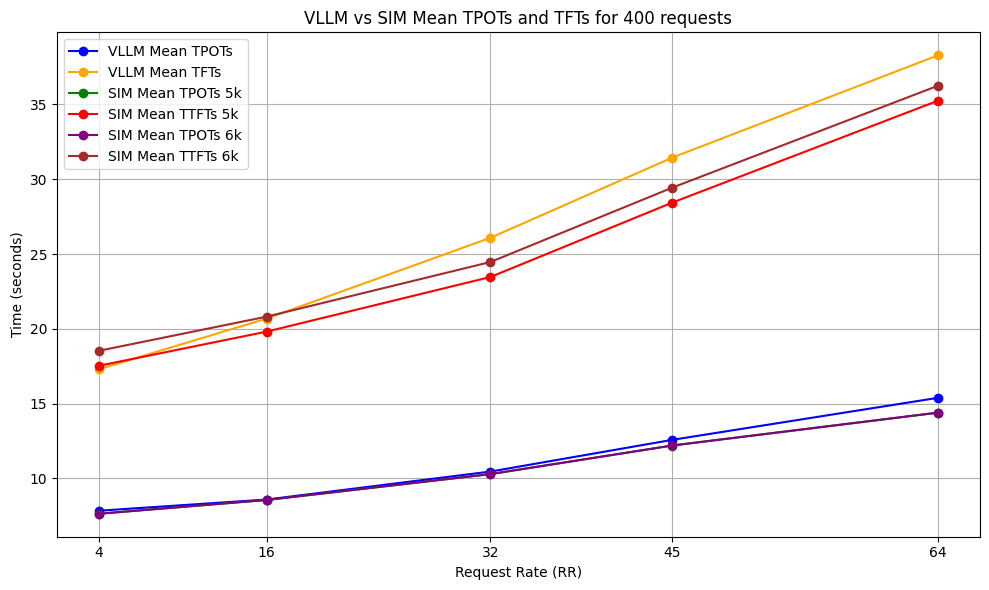

In [3]:
vllm_mean_tpots = [7.84, 8.59, 10.46, 12.58, 15.39]
vllm_mean_ttfts = [17.30,20.69, 26.09, 31.45, 38.29]

sim_mean_tpots_5k = [7.636, 8.559, 10.288, 12.199, 14.397]
sim_mean_ttfts_5k = [17.532, 19.816, 23.469,  28.441, 35.255]

sim_mean_tpots_6k = [7.640, 8.563, 10.292, 12.203, 14.401]
sim_mean_ttfts_6k = [18.532, 20.816, 24.469, 29.441, 36.255]

rr = [4, 16, 32, 45, 64]

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(rr, vllm_mean_tpots, marker='o', label='VLLM Mean TPOTs', color='blue')
plt.plot(rr, vllm_mean_ttfts, marker='o', label='VLLM Mean TFTs', color='orange')
plt.plot(rr, sim_mean_tpots_5k, marker='o', label='SIM Mean TPOTs 5k', color='green')
plt.plot(rr, sim_mean_ttfts_5k, marker='o', label='SIM Mean TTFTs 5k', color='red')
plt.plot(rr, sim_mean_tpots_6k, marker='o', label='SIM Mean TPOTs 6k', color='purple')
plt.plot(rr, sim_mean_ttfts_6k, marker='o', label='SIM Mean TTFTs 6k', color='brown')
plt.xlabel('Request Rate (RR)')
plt.ylabel('Time (seconds)')
plt.title('VLLM vs SIM Mean TPOTs and TFTs for 400 requests')
plt.xticks(rr)
plt.grid(True)
plt.legend()
plt.tight_layout()


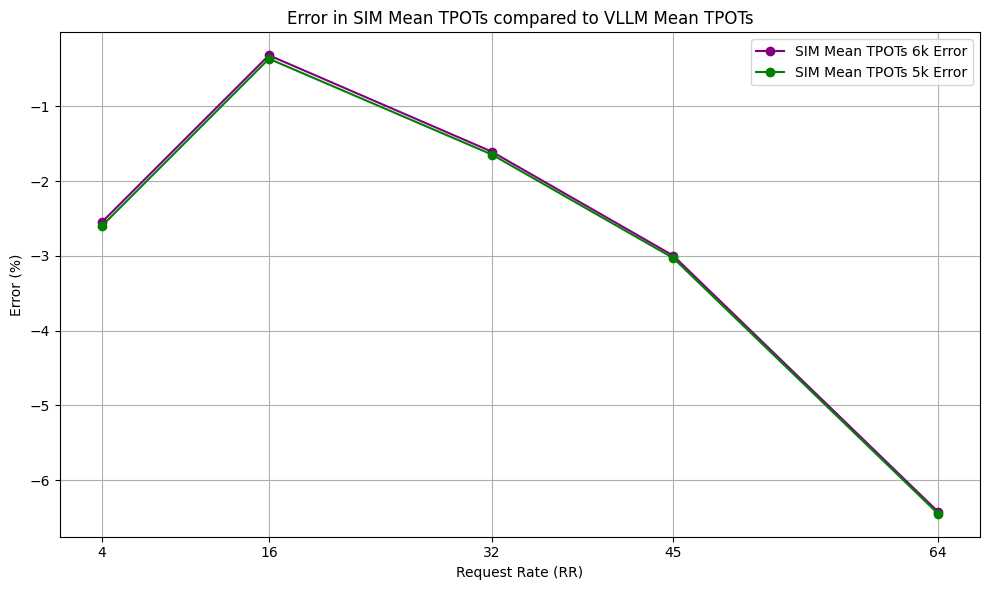

In [5]:
sim_mean_tpot_6k_err = (np.array(sim_mean_tpots_6k) - np.array(vllm_mean_tpots)) / np.array(vllm_mean_tpots) * 100
sim_mean_tpot_5k_err = (np.array(sim_mean_tpots_5k) - np.array(vllm_mean_tpots)) / np.array(vllm_mean_tpots) * 100

plt.figure(figsize=(10, 6))
plt.plot(rr, sim_mean_tpot_6k_err, marker='o', label='SIM Mean TPOTs 6k Error', color='purple')
plt.plot(rr, sim_mean_tpot_5k_err, marker='o', label='SIM Mean TPOTs 5k Error', color='green')
plt.xlabel('Request Rate (RR)')
plt.ylabel('Error (%)')
plt.title('Error in SIM Mean TPOTs compared to VLLM Mean TPOTs')
plt.xticks(rr)
plt.grid(True)
plt.legend()
plt.tight_layout()

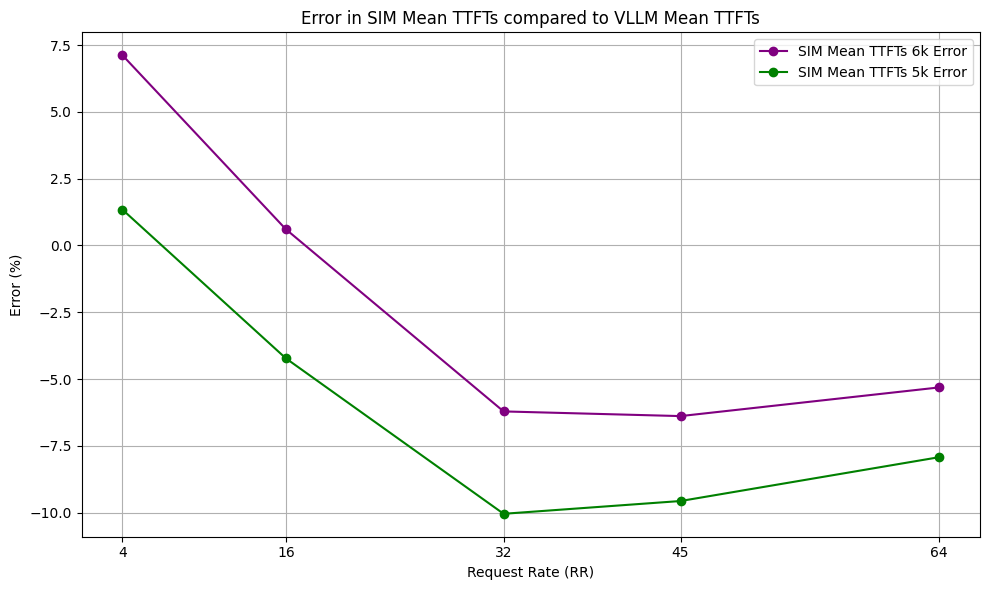

In [6]:
sim_mean_ttfts_6k_err = (np.array(sim_mean_ttfts_6k) - np.array(vllm_mean_ttfts)) / np.array(vllm_mean_ttfts) * 100
sim_mean_ttfts_5k_err = (np.array(sim_mean_ttfts_5k) - np.array(vllm_mean_ttfts)) / np.array(vllm_mean_ttfts) * 100
plt.figure(figsize=(10, 6))
plt.plot(rr, sim_mean_ttfts_6k_err, marker='o', label='SIM Mean TTFTs 6k Error', color='purple')
plt.plot(rr, sim_mean_ttfts_5k_err, marker='o', label='SIM Mean TTFTs 5k Error', color='green')
plt.xlabel('Request Rate (RR)')
plt.ylabel('Error (%)')
plt.title('Error in SIM Mean TTFTs compared to VLLM Mean TTFTs')
plt.xticks(rr)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
avg_sim_mean_tpot_6k_err = np.mean(sim_mean_tpot_6k_err)
avg_sim_mean_tpot_5k_err = np.mean(sim_mean_tpot_5k_err)
avg_sim_mean_ttfts_6k_err = np.mean(sim_mean_ttfts_6k_err)
avg_sim_mean_ttfts_5k_err = np.mean(sim_mean_ttfts_5k_err)
print(f"Average SIM Mean TPOTs 6k Error: {avg_sim_mean_tpot_6k_err:.2f}%")
print(f"Average SIM Mean TPOTs 5k Error: {avg_sim_mean_tpot_5k_err:.2f}%")
print(f"Average SIM Mean TTFTs 6k Error: {avg_sim_mean_ttfts_6k_err:.2f}%")
print(f"Average SIM Mean TTFTs 5k Error: {avg_sim_mean_ttfts_5k_err:.2f}%")

Average SIM Mean TPOTs 6k Error: -2.78%
Average SIM Mean TPOTs 5k Error: -2.82%
Average SIM Mean TTFTs 6k Error: -2.04%
Average SIM Mean TTFTs 5k Error: -6.08%


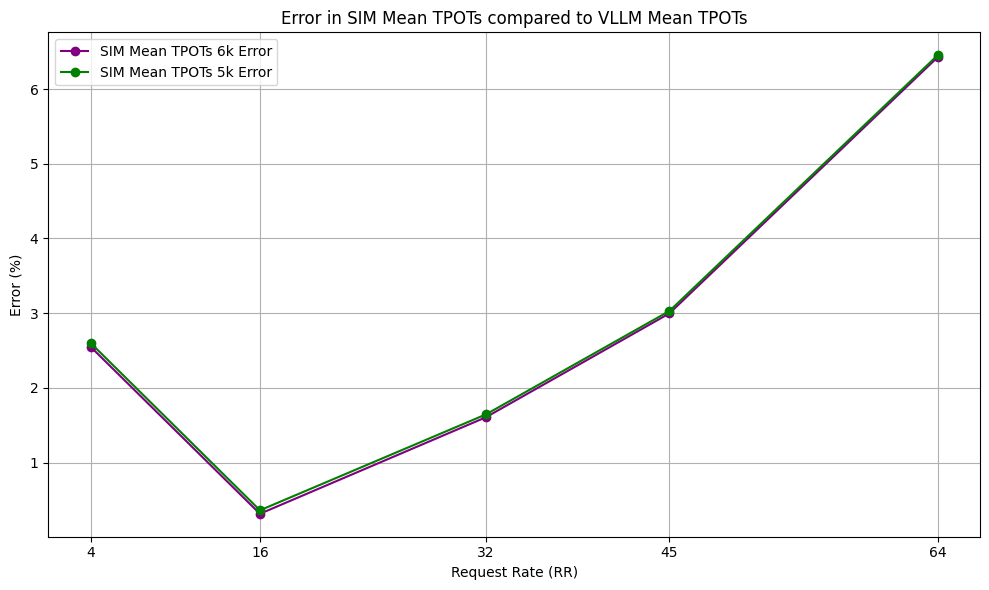

In [ ]:
sim_mean_tpot_6k_err_abs = abs(np.array(sim_mean_tpots_6k) - np.array(vllm_mean_tpots)) / np.array(vllm_mean_tpots) * 100
sim_mean_tpot_5k_err_abs = abs(np.array(sim_mean_tpots_5k) - np.array(vllm_mean_tpots)) / np.array(vllm_mean_tpots) * 100

plt.figure(figsize=(10, 6))
plt.plot(rr, sim_mean_tpot_6k_err_abs, marker='o', label='SIM Mean TPOTs 6k Error', color='purple')
plt.plot(rr, sim_mean_tpot_5k_err_abs, marker='o', label='SIM Mean TPOTs 5k Error', color='green')
plt.xlabel('Request Rate (RR)')
plt.ylabel('Error (%)')
plt.title('Error in SIM Mean TPOTs compared to VLLM Mean TPOTs (absolute)')
plt.xticks(rr)
plt.grid(True)
plt.legend()
plt.tight_layout()

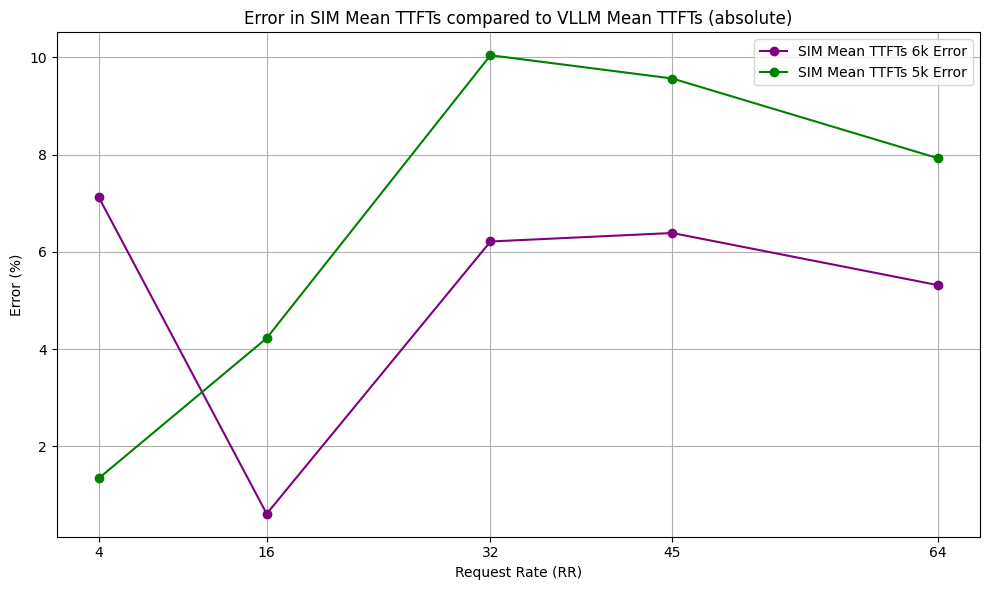

In [ ]:
sim_mean_ttfts_6k_err_abs = abs(np.array(sim_mean_ttfts_6k) - np.array(vllm_mean_ttfts)) / np.array(vllm_mean_ttfts) * 100
sim_mean_ttfts_5k_err_abs = abs(np.array(sim_mean_ttfts_5k) - np.array(vllm_mean_ttfts)) / np.array(vllm_mean_ttfts) * 100
plt.figure(figsize=(10, 6))
plt.plot(rr, sim_mean_ttfts_6k_err_abs, marker='o', label='SIM Mean TTFTs 6k Error', color='purple')
plt.plot(rr, sim_mean_ttfts_5k_err_abs, marker='o', label='SIM Mean TTFTs 5k Error', color='green')
plt.xlabel('Request Rate (RR)')
plt.ylabel('Error (%)')
plt.title('Error in SIM Mean TTFTs compared to VLLM Mean TTFTs (absolute)')
plt.xticks(rr)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
avg_sim_mean_tpot_6k_err_abs = np.mean(sim_mean_tpot_6k_err_abs)
avg_sim_mean_tpot_5k_err_abs = np.mean(sim_mean_tpot_5k_err_abs)
avg_sim_mean_ttfts_6k_err_abs = np.mean(sim_mean_ttfts_6k_err_abs)
avg_sim_mean_ttfts_5k_err_abs = np.mean(sim_mean_ttfts_5k_err_abs)
print(f"Average SIM Mean TPOTs 6k Error: {avg_sim_mean_tpot_6k_err_abs:.4f}%")
print(f"Average SIM Mean TPOTs 5k Error: {avg_sim_mean_tpot_5k_err_abs:.4f}%")
print(f"Average SIM Mean TTFTs 6k Error: {avg_sim_mean_ttfts_6k_err_abs:.4f}%")
print(f"Average SIM Mean TTFTs 5k Error: {avg_sim_mean_ttfts_5k_err_abs:.4f}%")

Average SIM Mean TPOTs 6k Error: 2.7789%
Average SIM Mean TPOTs 5k Error: 2.8176%
Average SIM Mean TTFTs 6k Error: 5.1292%
Average SIM Mean TTFTs 5k Error: 6.6210%
